In [1]:
!nvidia-smi

Sun Apr 18 13:31:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00661655days (571.67sec)


In [3]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

Cloning into 'custom_ImageNet'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 57 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [4]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [5]:
import sys
sys.path.append('/content/custom_ImageNet')

In [6]:
import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [8]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import datetime

!pip install tensorboardX
import tensorboardX as tbx
from tensorboardX import SummaryWriter


     |████████████████████████████████| 122kB 9.0MB/s 


In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!cp "drive/My Drive/ImageNet/retina_original_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/retina_original_ImagenetTest.zip" /content/
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [12]:
!7z x retina_original_ImagenetTrain.zip
!mv "content/retina_ImagenetTrain" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 305957198 bytes (292 MiB)

Extracting archive: retina_original_ImagenetTrain.zip
 23% 4096 Open              --
Path = retina_original_ImagenetTrain.zip
Type = zip
Physical Size = 305957198

  0%      3% 611 - content/retina_ImagenetTrain/bird/bird_902.jpg                                                           5% 994 - content/retina_ImagenetTrain/pineapple/pineapple_284.jpg                                                                   

In [13]:
!7z x retina_original_ImagenetTest.zip
!mv "content/retina_ImagenetTest" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 34489251 bytes (33 MiB)

Extracting archive: retina_original_ImagenetTest.zip
--
Path = retina_original_ImagenetTest.zip
Type = zip
Physical Size = 34489251

  0%     19% 401 - content/retina_ImagenetTest/cow/cow_000.jpg                                                       49% 1013 - content/retina_ImagenetTest/goat/goat_033.jpg                                                          86% 1747 - content/retina_ImagenetTest/mashed_potato/mashed_potato_051.jpg

In [14]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [15]:
rootpathTrain ='retina_ImagenetTrain/'
rootpathTest ='retina_ImagenetTest/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [16]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [17]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [18]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [19]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [20]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

14157

In [21]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


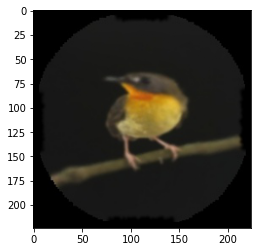

In [22]:
index = 2
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [23]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [24]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [25]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

In [26]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):
    
    log_path = F"/content/drive/My Drive/Colab Notebooks/Log/"
    now = datetime.datetime.now()
    folder = F"{name}"+now.strftime('%Y%m%d_%H%M%S')

    writer = tbx.SummaryWriter(log_path+folder)

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats;
    train_loss=0; val_loss=0; train_acc=0; val_acc=0; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_acc = 0       # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_acc += preds.eq(labels.view_as(preds)).sum().item()

            #print(epoch_acc)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_acc / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_loss=epoch_loss; train_acc=epoch_acc;
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_loss=epoch_loss; val_acc=epoch_acc;

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    total_name = name+".tar"
                    path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%2==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
            
        print('-------------')
        writer.add_scalars('/loss', {'train_loss': train_loss,
                                     'val_loss': val_loss
                                    }, epoch)
      
        writer.add_scalars('/acc', {'train_acc': train_acc,
                                    'val_acc': val_acc
                                    }, epoch)

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

### CONST data

In [27]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 10
else:
    NUM_EPOCS = 50

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Network model

In [28]:
# Load pre-trained VGG-11
use_pretrained = True
net = models.vgg11(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[6] = nn.Linear(in_features=4096, out_features=N_CLASSES)

net.cuda()

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

### Loss function

In [29]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Optimization method

In [30]:
# Store parameters through transfer learning, which are re-trained
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# Re-trained params
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# Non re-trained params keep their grads
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1 stores：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2 stores：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3 stores：", name)

    else:
        param.requires_grad = False
        print("Freazed：", name)

params_to_update_1 stores： features.0.weight
params_to_update_1 stores： features.0.bias
params_to_update_1 stores： features.3.weight
params_to_update_1 stores： features.3.bias
params_to_update_1 stores： features.6.weight
params_to_update_1 stores： features.6.bias
params_to_update_1 stores： features.8.weight
params_to_update_1 stores： features.8.bias
params_to_update_1 stores： features.11.weight
params_to_update_1 stores： features.11.bias
params_to_update_1 stores： features.13.weight
params_to_update_1 stores： features.13.bias
params_to_update_1 stores： features.16.weight
params_to_update_1 stores： features.16.bias
params_to_update_1 stores： features.18.weight
params_to_update_1 stores： features.18.bias
params_to_update_2 stores： classifier.0.weight
params_to_update_2 stores： classifier.0.bias
params_to_update_2 stores： classifier.3.weight
params_to_update_2 stores： classifier.3.bias
params_to_update_3 stores： classifier.6.weight
params_to_update_3 stores： classifier.6.bias


In [31]:
# Optimization setting
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

### Training & Test for model

In [32]:
LOAD_STATE = False
EPOCH = 100             # This values need to check the latest tar ffile name with epoch.
name = "04_5_vgg11"
folder_name = "VGG11"

if LOAD_STATE:
    stats=[];
    
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    best_model =net
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    model.load_state_dict( checkpoint["model_state_dict"] )
    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [33]:
best_model, stats = train_model(net, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/50
-------------



train Loss: 0.0437 Acc: 55.4496



val Loss: 0.0260 Acc: 72.7607
-------------
Epoch 2/50
-------------



train Loss: 0.0253 Acc: 73.1652



val Loss: 0.0224 Acc: 76.3493
-------------
Epoch 3/50
-------------



train Loss: 0.0205 Acc: 77.9402



val Loss: 0.0204 Acc: 78.8923
-------------
Epoch 4/50
-------------



train Loss: 0.0170 Acc: 82.0583



val Loss: 0.0191 Acc: 80.1639
-------------
Epoch 5/50
-------------



train Loss: 0.0149 Acc: 83.7748



val Loss: 0.0186 Acc: 80.8986
-------------
Epoch 6/50
-------------



train Loss: 0.0126 Acc: 86.4943



val Loss: 0.0183 Acc: 81.0116
-------------
Epoch 7/50
-------------



train Loss: 0.0107 Acc: 88.4580



val Loss: 0.0181 Acc: 81.4072
-------------
Epoch 8/50
-------------



train Loss: 0.0091 Acc: 89.9767



val Loss: 0.0181 Acc: 81.8310
-------------
Epoch 9/50
-------------



train Loss: 0.0077 Acc: 91.6649



val Loss: 0.0183 Acc: 82.1701
-------------
Epoch 10/50
-------------



train Loss: 0.0065 Acc: 93.2754



val Loss: 0.0191 Acc: 81.1811
-------------
Epoch 11/50
-------------



train Loss: 0.0054 Acc: 94.3279



val Loss: 0.0195 Acc: 81.8028
-------------
Epoch 12/50
-------------



train Loss: 0.0044 Acc: 95.3097



val Loss: 0.0202 Acc: 82.1984
-------------
Epoch 13/50
-------------



train Loss: 0.0038 Acc: 96.0726



val Loss: 0.0204 Acc: 81.6897
-------------
Epoch 14/50
-------------



train Loss: 0.0032 Acc: 96.7154



val Loss: 0.0203 Acc: 82.5374
-------------
Epoch 15/50
-------------



train Loss: 0.0025 Acc: 97.5277



val Loss: 0.0217 Acc: 82.3114
-------------
Epoch 16/50
-------------



train Loss: 0.0023 Acc: 97.7255



val Loss: 0.0225 Acc: 82.3396
-------------
Epoch 17/50
-------------



train Loss: 0.0020 Acc: 98.1069



val Loss: 0.0224 Acc: 81.9441
-------------
Epoch 18/50
-------------



train Loss: 0.0016 Acc: 98.3895



val Loss: 0.0230 Acc: 81.9158
-------------
Epoch 19/50
-------------



train Loss: 0.0016 Acc: 98.4743



val Loss: 0.0234 Acc: 81.7745
-------------
Epoch 20/50
-------------



train Loss: 0.0013 Acc: 98.7851



val Loss: 0.0241 Acc: 82.4244
-------------
Epoch 21/50
-------------



train Loss: 0.0013 Acc: 98.7992



val Loss: 0.0239 Acc: 82.0571
-------------
Epoch 22/50
-------------



train Loss: 0.0010 Acc: 99.1594



val Loss: 0.0240 Acc: 82.0571
-------------
Epoch 23/50
-------------



train Loss: 0.0009 Acc: 99.1665



val Loss: 0.0248 Acc: 82.3962
-------------
Epoch 24/50
-------------



train Loss: 0.0009 Acc: 99.1453



val Loss: 0.0255 Acc: 81.8593
-------------
Epoch 25/50
-------------



train Loss: 0.0008 Acc: 99.2230



val Loss: 0.0249 Acc: 81.9723
-------------
Epoch 26/50
-------------



train Loss: 0.0008 Acc: 99.2936



val Loss: 0.0260 Acc: 82.3962
-------------
Epoch 27/50
-------------



train Loss: 0.0007 Acc: 99.5197



val Loss: 0.0258 Acc: 82.4527
-------------
Epoch 28/50
-------------



train Loss: 0.0007 Acc: 99.4137



val Loss: 0.0265 Acc: 82.1136
-------------
Epoch 29/50
-------------



train Loss: 0.0007 Acc: 99.3925



val Loss: 0.0273 Acc: 81.8028
-------------
Epoch 30/50
-------------



train Loss: 0.0006 Acc: 99.5267



val Loss: 0.0270 Acc: 82.2831
-------------
Epoch 31/50
-------------



train Loss: 0.0006 Acc: 99.4702



val Loss: 0.0266 Acc: 82.1418
-------------
Epoch 32/50
-------------



train Loss: 0.0006 Acc: 99.5479



val Loss: 0.0268 Acc: 81.8593
-------------
Epoch 33/50
-------------



train Loss: 0.0005 Acc: 99.6327



val Loss: 0.0272 Acc: 82.1984
-------------
Epoch 34/50
-------------



train Loss: 0.0004 Acc: 99.6186



val Loss: 0.0285 Acc: 81.8875
-------------
Epoch 35/50
-------------



train Loss: 0.0004 Acc: 99.6398



val Loss: 0.0281 Acc: 82.5374
-------------
Epoch 36/50
-------------



train Loss: 0.0005 Acc: 99.5762



val Loss: 0.0275 Acc: 81.7180
-------------
Epoch 37/50
-------------



train Loss: 0.0005 Acc: 99.6115



val Loss: 0.0278 Acc: 82.4809
-------------
Epoch 38/50
-------------



train Loss: 0.0004 Acc: 99.6751



val Loss: 0.0273 Acc: 82.3114
-------------
Epoch 39/50
-------------



train Loss: 0.0005 Acc: 99.6398



val Loss: 0.0278 Acc: 82.1984
-------------
Epoch 40/50
-------------



train Loss: 0.0004 Acc: 99.6609



val Loss: 0.0291 Acc: 81.7463
-------------
Epoch 41/50
-------------



train Loss: 0.0005 Acc: 99.6327



val Loss: 0.0282 Acc: 82.0006
-------------
Epoch 42/50
-------------



train Loss: 0.0003 Acc: 99.7386



val Loss: 0.0282 Acc: 82.4809
-------------
Epoch 43/50
-------------



train Loss: 0.0003 Acc: 99.6821



val Loss: 0.0286 Acc: 82.1136
-------------
Epoch 44/50
-------------



train Loss: 0.0003 Acc: 99.7175



val Loss: 0.0283 Acc: 82.4244
-------------
Epoch 45/50
-------------



train Loss: 0.0004 Acc: 99.6468



val Loss: 0.0283 Acc: 81.7463
-------------
Epoch 46/50
-------------



train Loss: 0.0003 Acc: 99.6963



val Loss: 0.0290 Acc: 81.7180
-------------
Epoch 47/50
-------------



train Loss: 0.0003 Acc: 99.7457



val Loss: 0.0288 Acc: 82.0853
-------------
Epoch 48/50
-------------



train Loss: 0.0003 Acc: 99.7952



val Loss: 0.0302 Acc: 81.7180
-------------
Epoch 49/50
-------------



train Loss: 0.0003 Acc: 99.7386



val Loss: 0.0291 Acc: 81.9441
-------------
Epoch 50/50
-------------



train Loss: 0.0003 Acc: 99.7457



val Loss: 0.0299 Acc: 82.0006
-------------
Lowest training loss 0.0002729799546618664
Lowest validation loss 0.018057465170123004
Highest training accuracy 99.79515434060889
Highest validation accuracy 82.53743995478949
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/04_5_vgg11_Loss _.png04_5_vgg11_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/04_5_vgg11_Accuracy _.png04_5_vgg11_Accuracy _.png


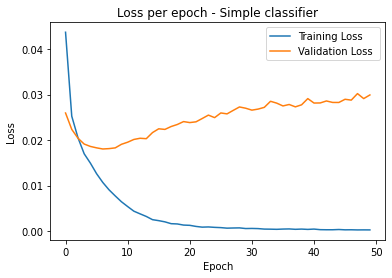

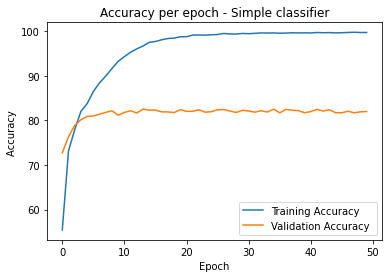

In [34]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 0.6735 
Testing Accuracy: 1634/2000 (81.70%)
apple Class Accuracy: 69/100 (69.00%)
banana Class Accuracy: 86/100 (86.00%)
bear Class Accuracy: 90/100 (90.00%)
bell_pepper Class Accuracy: 78/100 (78.00%)
bird Class Accuracy: 82/100 (82.00%)
broccoli Class Accuracy: 85/100 (85.00%)
cat Class Accuracy: 81/100 (81.00%)
cauliflower Class Accuracy: 79/100 (79.00%)
cow Class Accuracy: 76/100 (76.00%)
dog Class Accuracy: 71/100 (71.00%)
elephant Class Accuracy: 93/100 (93.00%)
fox Class Accuracy: 91/100 (91.00%)
goat Class Accuracy: 65/100 (65.00%)
horse Class Accuracy: 81/100 (81.00%)
mashed_potato Class Accuracy: 93/100 (93.00%)
orange Class Accuracy: 82/100 (82.00%)
pineapple Class Accuracy: 81/100 (81.00%)
pomegranate Class Accuracy: 82/100 (82.00%)
tomato Class Accuracy: 75/100 (75.00%)
zebra Class Accuracy: 94/100 (94.00%)
Classifier has Acc=0.817 P=0.817 R=0.819 F1=0.817
               precision    recall  f1-score   support

        apple       0.69      0.69      0.69     

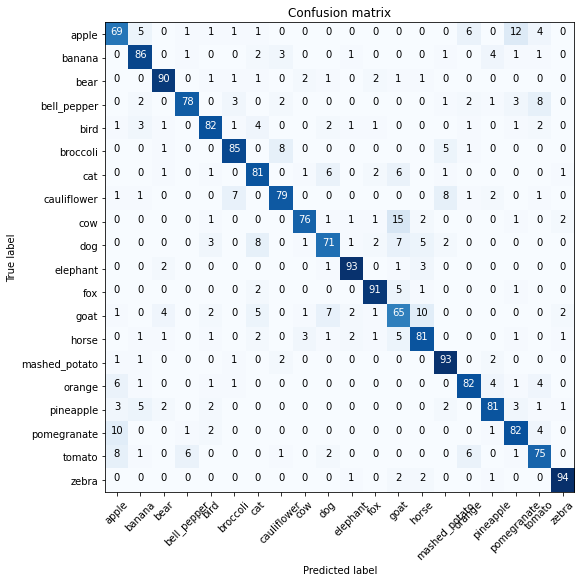

In [35]:
result = test_model(best_model, criterion, name)